In [1]:
import os
import numpy as np
import pandas as pd
import multiprocessing as mp
import lightgbm as lgb

from features import data_features_new as feat, feature_selection
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# feature selection
import eli5
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from eli5.sklearn import PermutationImportance
from lightgbm import plot_importance


In [2]:
DATA_PATH = './data'  # data csv file 이 있는 경로 기입
DATA_FILE_LIST = os.listdir(DATA_PATH)

In [3]:
DATA_FILE_LIST

['iqr_feat_crypto.pkl',
 'scaled_m5_r20.pkl',
 'total_feat_crypto.pkl',
 'upbit_min_data_KRW-ADA_20210320_20220324.csv',
 'upbit_min_data_KRW-AERGO_20210122_20220324.csv',
 'upbit_min_data_KRW-AHT_20201227_20220324.csv',
 'upbit_min_data_KRW-ALL.pkl',
 'upbit_min_data_KRW-ANKR_20210131_20220324.csv',
 'upbit_min_data_KRW-ARDR_20201228_20220324.csv',
 'upbit_min_data_KRW-ARK_20210103_20220324.csv',
 'upbit_min_data_KRW-ATOM_20210309_20220324.csv',
 'upbit_min_data_KRW-BAT_20210208_20220324.csv',
 'upbit_min_data_KRW-BCH_20210228_20220324.csv',
 'upbit_min_data_KRW-BORA_20210309_20220324.csv',
 'upbit_min_data_KRW-BSV_20210130_20220324.csv',
 'upbit_min_data_KRW-BTC_20210322_20220324.csv',
 'upbit_min_data_KRW-BTG_20210223_20220324.csv',
 'upbit_min_data_KRW-BTT_20210314_20220324.csv',
 'upbit_min_data_KRW-CHZ_20210303_20220324.csv',
 'upbit_min_data_KRW-CRE_20210207_20220324.csv',
 'upbit_min_data_KRW-CVC_20210201_20220324.csv',
 'upbit_min_data_KRW-DKA_20210129_20220324.csv',
 'upbit_m

In [4]:
def concat_data(data_path):
    # 분산 저장된 분봉 데이터를 순차적으로 로드하여, DataFrame 으로 합침
    df_tmp = pd.DataFrame()
    for path in tqdm(data_path):
        if path.endswith('.csv'):
            file_path = os.path.join(DATA_PATH, path)
            df_tmp = pd.concat([df_tmp, pd.read_csv(file_path)])
    return df_tmp

In [5]:
# windsering, IQR 함수
def cal_iqr(series: pd.Series):
    tmp = series.copy()
    
    # 데이터의 4분위중 1, 4분위값을 탐색
    Q1 = tmp.quantile(0.25)
    Q3 = tmp.quantile(0.75)
    
    # 1, 4분위값의 차이, Inter Quantile Range IQR을 산출
    iqr = Q3 - Q1
    
    # 이상치의 제한값을 iqr의 1.5배로 설정
    outlier_step = 1.5 * iqr
    
    # 이상치의 제한값을 넘어서는 이상치들을 제한값으로 한정
    lower_bound = tmp < Q1 - outlier_step
    upper_bound = tmp > Q3 + outlier_step
    tmp[lower_bound] = Q1 - outlier_step
    tmp[upper_bound] = Q3 + outlier_step
    
    return tmp

In [78]:
def result_dataframe(clf, X_train, X_test, y_train, y_test, features=[]):
    # dataset
    if features:
        X_train = X_train[features]
        X_test = X_test[features]
    
    # result
    result = []
    for x, y in zip([X_train, X_test], [y_train, y_test]):
        y_pred = clf.predict(x)
        y_true = y.values
        
        acc = accuracy_score(y_true, y_pred)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        roc = roc_auc_score(y_true, y_pred)

        result.append([acc, pre, rec, f1, roc])
        
    df_result = pd.DataFrame(result)
    df_result.index = ["train", "test"]
    df_result.columns = ["accuracy", "precision", "recall", "f1", "roc"]
    
    return df_result

In [40]:
def rolling_cook_dataset(df: pd.DataFrame, ticker_list: list=None, n: int=5, window: int=20, is_cross: bool=False):
    if ticker_list is None:
        ticker_list = df['ticker'].drop_duplicates().to_list()
    tmp_df = df.copy(deep=True)
    tmp_df['median'] = (tmp_df['high'] + tmp_df['low']) * 0.5
    drop_cols = ['open', 'high', 'low', 'close', 'volume', 'ticker', 'median']
    
    df_ticker_all, df_target_all = pd.DataFrame(), pd.DataFrame()
    last_no_samples = 0
    for ticker in tqdm(ticker_list):
        ticker_df = tmp_df[df['ticker']==ticker]
        sub_df = ticker_df.drop(columns=drop_cols)
        sub_arr = sub_df.values
        sub_cols = sub_df.columns
        tmp_target = (ticker_df['median'].shift(-n) - ticker_df['median']).apply(lambda x: 1 if x > 0 else 0)       
        
        if is_cross:
            num_split = len(sub_arr) // window
            split_arr = np.array_split(sub_arr, num_split)
          
            for idx, arr_ in enumerate(split_arr):
                df_subset = pd.DataFrame(arr_, columns=sub_cols)
                df_subset['no_samples'] = idx
                
                if len(arr_) == window:
                    df_ticker_all = pd.concat([df_ticker_all, df_subset], ignore_index=True)
                elif len(arr_) > window:
                    df_ticker_all = pd.concat([df_ticker_all, df_subset.iloc[:window]], ignore_index=True)
                else:
                    print(f'insufficient length {arr_.shape[0]} x {arr_.shape[1]}')
            
            df_target_all = pd.concat([df_target_all, tmp_target.iloc[:len(df_ticker_all)]], ignore_index=True)
        else:
            for i in range(len(sub_arr) - window + 1):
                df_subset = pd.DataFrame(sub_arr[i:i+window], columns=sub_cols)
                df_subset['no_samples'] = i + last_no_samples
                if last_no_samples > 0 :
                    df_subset['no_samples'] += 1 # 임의의 한 코인 Data 재구성이 끝난 후, 새 코인이 시작될 때 샘플수 카운팅이 직전값과 동일하지 않게, 1 을 더해줌.
                df_subset['ticker'] = ticker
                df_ticker_all = pd.concat([df_ticker_all, df_subset], ignore_index=True)
            
            reset_target = tmp_target.iloc[window-1:].reset_index()
            reset_target['ticker'] = ticker
            df_target_all = pd.concat([df_target_all, reset_target], ignore_index=True)
        last_no_samples = df_ticker_all['no_samples'].iloc[-1]
        
    return df_ticker_all, df_target_all


In [13]:
df_raw = concat_data(DATA_FILE_LIST[:5])  

100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


In [14]:
df_raw.head()

,candle_date_time_utc,market,candle_date_time_utc.1,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,unit
0,2021-03-20 13:10:00,KRW-ADA,2021-03-20T13:10:00,2021-03-20T22:10:00,1480.0,1480.0,1475.0,1480.0,1616245853420,3.897286e+07,26343.438848,1
1,2021-03-20 13:11:00,KRW-ADA,2021-03-20T13:11:00,2021-03-20T22:11:00,1480.0,1480.0,1475.0,1480.0,1616245920120,4.011098e+07,27140.699591,1
2,2021-03-20 13:12:00,KRW-ADA,2021-03-20T13:12:00,2021-03-20T22:12:00,1480.0,1480.0,1475.0,1480.0,1616245979323,1.762409e+08,119339.691339,1
3,2021-03-20 13:13:00,KRW-ADA,2021-03-20T13:13:00,2021-03-20T22:13:00,1480.0,1480.0,1475.0,1480.0,1616246040140,8.660259e+07,58537.574946,1
4,2021-03-20 13:14:00,KRW-ADA,2021-03-20T13:14:00,2021-03-20T22:14:00,1480.0,1480.0,1475.0,1475.0,1616246097894,1.186877e+07,8034.390847,1


In [16]:
freq = '10T'
ticker_list = df_raw["market"].unique().tolist()
pick_cols = ['candle_date_time_utc', 'market', 'opening_price', 'high_price', 'low_price', 'trade_price', 'candle_acc_trade_volume']
print(ticker_list)

['KRW-ADA', 'KRW-AERGO']


In [17]:
df_total_feat = pd.DataFrame()
df_total_target = pd.DataFrame()
days = [1, 3, 5, 10]

# 각 코인별로 10분봉으로 변환하여 Feature 생성
for ticker in tqdm(ticker_list):
    resmpl_df = pd.DataFrame()
    df_ticker = df_raw.loc[df_raw["market"]==ticker, pick_cols].copy()

    df_ticker.columns = ['time', 'ticker', 'open', 'high', 'low', 'close', 'volume']
    df_ticker.sort_values("time", ascending=True, inplace=True)
    df_ticker.set_index(pd.to_datetime(df_ticker['time']), inplace=True)

    # 10분봉으로 upsampling
    resmpl_df['open'] = df_ticker['open'].resample(freq, label='right', closed='right').ohlc()['open']
    resmpl_df['high'] = df_ticker['high'].resample(freq, label='right', closed='right').max()
    resmpl_df['low'] = df_ticker['low'].resample(freq, label='right', closed='right').min()
    resmpl_df['close'] = df_ticker['close'].resample(freq, label='right', closed='right').ohlc()['close']
    resmpl_df['volume'] = df_ticker['volume'].resample(freq, label='right', closed='right').sum()
    resmpl_df['ticker'] = ticker
    
    # 기본 피처 생성
    df_feature = feat.get_feature(resmpl_df)
    df_total_feat = pd.concat([df_total_feat, df_feature.reset_index()])
    
    # Target 설정
    df_target = pd.DataFrame()
    for i in days:
        df_target[f"target_close_{i}"] = (df_feature["close"].shift(-i) - df_feature["close"]).dropna()
    
    df_target = df_target.applymap(lambda x: 1 if x > 0 else 0)
    df_target['ticker'] = ticker
    
    df_total_target = pd.concat([df_total_target, df_target])
    
    

  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
100%|██████████| 2/2 [00:53<00:00, 26.76s/it]


In [18]:
drop_cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'ticker']
df_total_feat[df_total_feat['ticker'] == 'KRW-ADA'].shape

(53073, 125)

In [19]:
sel_df_feat = df_total_feat.drop(columns=drop_cols).fillna(method='ffill')

c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\pandas_profiling\model\correlations.py:67: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/pandas-profiling/issues
(include the error message: 'cannot specify integer `bins` when input data contains infinity')
  warnings.warn(
c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\missingno\missingno.py:254: UserWarn

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

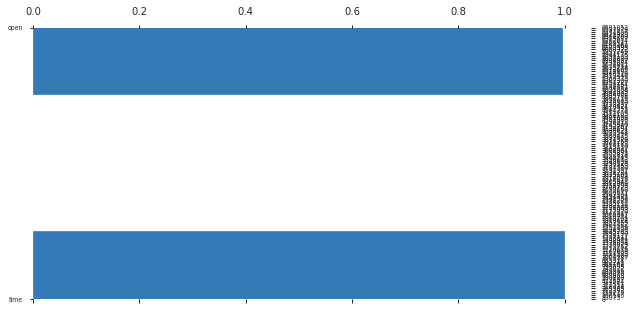

In [53]:
import pandas_profiling
pr = df_total_feat[df_total_feat['ticker'] == 'KRW-ADA'].profile_report()
pr.to_file('./pr_report.html')
# sns.boxplot(data=sel_df_feat)


In [20]:
df_iqr_data = pd.DataFrame() 
for ticker in tqdm(ticker_list):
    tmp_ticker = sel_df_feat.loc[df_total_feat["ticker"]==ticker].copy()
    
    tmp_feat_all = pd.DataFrame()  
    for col in tmp_ticker.columns:
        if tmp_ticker.shape[0] == (tmp_ticker[col] == 0).sum():
            print(col)
            print(tmp_ticker[col].describe())
            continue
        tmp_series = cal_iqr(tmp_ticker[col])
        tmp_feat_all = pd.concat([tmp_feat_all, tmp_series], axis=1)
        
    # tmp_feat_all['ticker'] = ticker
    print(ticker)
    print(tmp_feat_all.shape)
    df_iqr_data = pd.concat([df_iqr_data, tmp_feat_all], join='outer')
    
df_iqr_data = pd.concat([df_total_feat[drop_cols], df_iqr_data], axis=1, join='outer')

 50%|█████     | 1/2 [00:02<00:02,  2.42s/it]

KRW-ADA
(53073, 118)


100%|██████████| 2/2 [00:04<00:00,  2.49s/it]

KRW-AERGO
(61239, 118)


In [55]:
print(df_iqr_data.head())
print(df_iqr_data.tail())

                 time    open    high     low   close         volume   ticker  \
0 2021-03-20 13:10:00  1480.0  1480.0  1475.0  1480.0   26343.438848  KRW-ADA   
1 2021-03-20 13:20:00  1480.0  1480.0  1475.0  1475.0  658109.212608  KRW-ADA   
2 2021-03-20 13:30:00  1475.0  1480.0  1470.0  1470.0  428598.456664  KRW-ADA   
3 2021-03-20 13:40:00  1475.0  1475.0  1470.0  1470.0  261951.847279  KRW-ADA   
4 2021-03-20 13:50:00  1475.0  1475.0  1470.0  1470.0  364211.759152  KRW-ADA   

   transaction_amount  pct_change_close_5  pct_change_volume_5  ...  \
0        3.898829e+07                 NaN                  NaN  ...   
1        9.707111e+08                 NaN                  NaN  ...   
2        6.300397e+08                 NaN                  NaN  ...   
3        3.850692e+08                 NaN                  NaN  ...   
4        5.353913e+08                 NaN                  NaN  ...   

   trend_aroon_ind  trend_psar  trend_psar_up  trend_psar_up_indicator  \
0           

In [21]:
df_scaled = pd.DataFrame()
window = 20
n = 5

In [22]:
for ticker in tqdm(ticker_list):
    df_ticker = df_iqr_data[df_iqr_data["ticker"] == ticker].copy().iloc[:-n]
    df_ticker = df_ticker.replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
    scaled = feature_selection.scaling_data(df_ticker.drop(columns=drop_cols), window=window, scale="rob")
    scaled.loc[:, drop_cols] = df_ticker[drop_cols].copy()
    df_scaled = pd.concat([df_scaled, scaled])

  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
c:\Users\onsemiro7988\Anaconda3\envs\DL_Envs\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=o

In [23]:
df_scaled.head()

,transaction_amount,pct_change_close_5,pct_change_volume_5,std_close_5,std_volume_5,kyle_lambda_5,amihud_lambda5,hasbrouck_lambda5,bekker_parkinson_vol5,corwin_schultz_estimator5,...,daily_log_return,cumlative_return,daily_maximum_return,time,open,high,low,close,volume,ticker
0,-1.009112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.5,NaN,2021-03-20 13:10:00,1480.0,1480.0,1475.0,1480.0,26343.438848,KRW-ADA
1,0.371027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.998305,1.0,-0.994895,2021-03-20 13:20:00,1480.0,1480.0,1475.0,1475.0,658109.212608,KRW-ADA
2,-0.133602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.001695,0.5,-0.003373,2021-03-20 13:30:00,1475.0,1480.0,1470.0,1470.0,428598.456664,KRW-ADA
3,-0.496471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.5,0.000000,2021-03-20 13:40:00,1475.0,1475.0,1470.0,1470.0,261951.847279,KRW-ADA
4,-0.273802,NaN,NaN,0.015488,-0.158082,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.5,0.000000,2021-03-20 13:50:00,1475.0,1475.0,1470.0,1470.0,364211.759152,KRW-ADA


<AxesSubplot:>

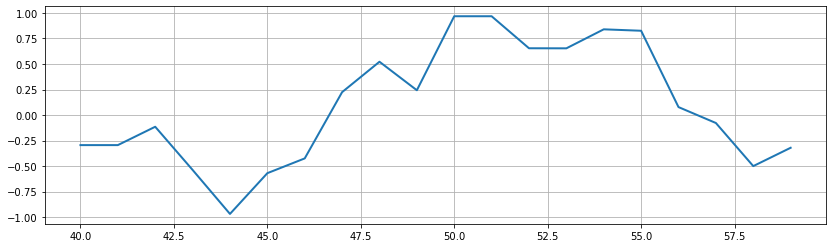

In [97]:
df_scaled.iloc[2*window:3*window, 25].plot()

In [41]:
df_roll_data, df_target = rolling_cook_dataset(df_scaled, n=n, window=window)

100%|██████████| 2/2 [16:06:53<00:00, 29006.77s/it] 


In [42]:
df_target.tail()

,index,median,ticker
114237,61215,0,KRW-AERGO
114238,61216,0,KRW-AERGO
114239,61217,0,KRW-AERGO
114240,61218,0,KRW-AERGO
114241,61219,0,KRW-AERGO


In [61]:
df_roll_data['no_samples'].value_counts()

0         20
76157     20
76168     20
76167     20
76166     20
          ..
38077     20
38076     20
38075     20
38074     20
114241    20
Name: no_samples, Length: 114242, dtype: int64

In [59]:
df_roll_data.loc[df_roll_data['ticker'] == 'KRW-AERGO', 'no_samples'] = df_roll_data.loc[df_roll_data['ticker'] == 'KRW-AERGO', 'no_samples'] + 1

In [46]:
df_roll_data.shape, df_target.shape

((2284840, 121), (114242, 3))

<AxesSubplot:>

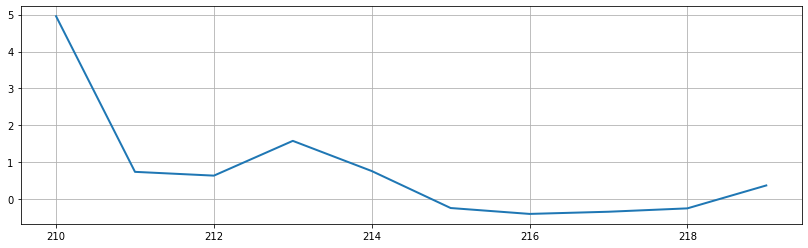

In [54]:
df_roll_data.loc[df_roll_data['no_samples'] == 10, df_roll_data.columns[20]].plot()

In [60]:
grouped = df_roll_data.groupby('no_samples')
grouped.last()

,transaction_amount,pct_change_close_5,pct_change_volume_5,std_close_5,std_volume_5,kyle_lambda_5,amihud_lambda5,hasbrouck_lambda5,bekker_parkinson_vol5,corwin_schultz_estimator5,...,trend_psar_up,trend_psar_up_indicator,trend_psar_down,trend_psar_down_indicator,daily_return,daily_log_return,cumlative_return,daily_maximum_return,time,ticker
no_samples,,,,,,,,,,,,,,,,,,,,,
0,1.583719,-0.671582,1.074611,4.169852e-01,0.349973,-0.500815,-0.489368,-0.166967,0.885614,-0.246763,...,1.002131,0.0,-0.496910,0.0,0.000000,0.000000,-1.5,1.022340,2021-03-20 16:20:00,KRW-ADA
1,5.069833,-0.882808,2.927479,3.012122e-01,3.271687,-0.602444,-0.604145,-0.460954,1.008918,-0.371398,...,0.000000,0.0,1.100409,0.0,0.501504,0.500644,0.0,0.001723,2021-03-20 16:30:00,KRW-ADA
2,2.167141,-0.882808,4.653699,0.000000e+00,2.623314,-0.602444,-0.604145,-0.460954,1.557573,-0.371398,...,0.000000,0.0,0.974353,0.0,0.000000,0.000000,0.0,0.499569,2021-03-20 16:40:00,KRW-ADA
3,0.789071,-1.324211,1.873330,-6.987878e-01,2.112428,-0.456126,-0.457831,-0.245993,-0.421921,1.811056,...,0.000000,0.0,0.850817,0.0,-0.499780,-0.500644,-0.8,0.000000,2021-03-20 16:50:00,KRW-ADA
4,0.985290,-0.891940,0.072873,0.000000e+00,2.408204,-0.466376,-0.463910,-0.342255,0.820013,-0.371398,...,0.000000,0.0,0.729752,0.0,-1.003007,-1.006488,-2.4,-0.499569,2021-03-20 17:00:00,KRW-ADA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114237,-0.737605,0.665903,-0.410824,-6.845459e-01,0.100917,-0.069333,-0.065120,-0.126212,-0.493738,1.021734,...,0.000000,0.0,-0.430487,0.0,0.802827,0.802256,0.0,0.446530,2022-03-24 02:30:00,KRW-AERGO
114238,0.262141,1.111911,-0.324732,6.233863e-14,-0.366503,0.115189,0.118005,0.249764,0.001630,-0.009214,...,0.000000,0.0,-0.515772,0.0,0.800000,0.799436,0.5,0.000000,2022-03-24 02:40:00,KRW-AERGO
114239,0.136584,1.111911,0.050100,-6.233863e-14,-0.354340,0.115189,0.118005,0.249764,1.527676,-0.391519,...,282.000000,0.0,-164.931273,0.0,0.000000,0.000000,0.5,-0.443396,2022-03-24 02:50:00,KRW-AERGO


In [62]:
raw_data = grouped.last().drop(columns=['time', 'ticker'])

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(raw_data, df_target, test_size=0.33, random_state=42, shuffle=True)

In [73]:
X_train.fillna(method='bfill', inplace=True)
X_test.fillna(method='bfill', inplace=True)

In [74]:
clf_pi = lgb.LGBMClassifier(objective="binary")
clf_pi.fit(X_train, y_train['median'])
perm = PermutationImportance(clf_pi, scoring="accuracy", random_state=42).fit(X_test, y_test['median'])

In [76]:
features_pi = eli5.explain_weights_df(perm, feature_names=X_test.columns.tolist())
features_pi = features_pi[features_pi["weight"] > 0]["feature"].values.tolist()


['trend_psar_down', 'daily_return', 'trend_psar_up', 'cumlative_return', 'trend_wma_5', 'trend_cci', 'daily_maximum_return', 'trend_ema_5', 'volatility_dch', 'daily_log_return', 'volatility_dcl', 'volume_obv', 'trend_stc', 'trend_psar', 'volatility_bbp', 'volume_em', 'volatility_ui', 'std_close_5', 'std_close_10', 'trend_sma_10', 'momentum_uo', 'trend_ichimoku_base', 'volatility_bbh', 'volatility_bbl', 'trend_vortex_ind_pos', 'trend_kst_sig', 'volume_vwap', 'volatility_kch', 'volatility_kcl', 'trend_kst_diff', 'momentum_pvo_signal', 'trend_aroon_down', 'pct_change_close_10', 'trend_ema_20', 'std_close_20', 'trend_trix', 'trend_aroon_up', 'pct_change_close_20', 'pct_change_close_5', 'momentum_stoch_rsi', 'trend_mass_index', 'volume_mfi', 'trend_vortex_ind_diff', 'trend_ichimoku_b', 'momentum_ppo', 'volatility_bbw', 'trend_macd_diff', 'volatility_kcm', 'volatility_dcw', 'momentum_tsi', 'momentum_pvo_hist', 'momentum_ppo_hist', 'volatility_dcm', 'momentum_pvo', 'std_volume_20', 'momentum_

In [79]:
print(len(features_pi), features_pi)

85 ['trend_psar_down', 'daily_return', 'trend_psar_up', 'cumlative_return', 'trend_wma_5', 'trend_cci', 'daily_maximum_return', 'trend_ema_5', 'volatility_dch', 'daily_log_return', 'volatility_dcl', 'volume_obv', 'trend_stc', 'trend_psar', 'volatility_bbp', 'volume_em', 'volatility_ui', 'std_close_5', 'std_close_10', 'trend_sma_10', 'momentum_uo', 'trend_ichimoku_base', 'volatility_bbh', 'volatility_bbl', 'trend_vortex_ind_pos', 'trend_kst_sig', 'volume_vwap', 'volatility_kch', 'volatility_kcl', 'trend_kst_diff', 'momentum_pvo_signal', 'trend_aroon_down', 'pct_change_close_10', 'trend_ema_20', 'std_close_20', 'trend_trix', 'trend_aroon_up', 'pct_change_close_20', 'pct_change_close_5', 'momentum_stoch_rsi', 'trend_mass_index', 'volume_mfi', 'trend_vortex_ind_diff', 'trend_ichimoku_b', 'momentum_ppo', 'volatility_bbw', 'trend_macd_diff', 'volatility_kcm', 'volatility_dcw', 'momentum_tsi', 'momentum_pvo_hist', 'momentum_ppo_hist', 'volatility_dcm', 'momentum_pvo', 'std_volume_20', 'moment

In [80]:
clf_pi = lgb.LGBMClassifier(objective="binary")
clf_pi.fit(X_train[features_pi], y_train['median'])

result_dataframe(clf_pi, X_train[features_pi], X_test[features_pi], y_train['median'], y_test['median'], features=features_pi)

,accuracy,precision,recall,f1,roc
train,0.794936,0.790442,0.744263,0.766658,0.790551
test,0.764615,0.754257,0.710225,0.731579,0.759819


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

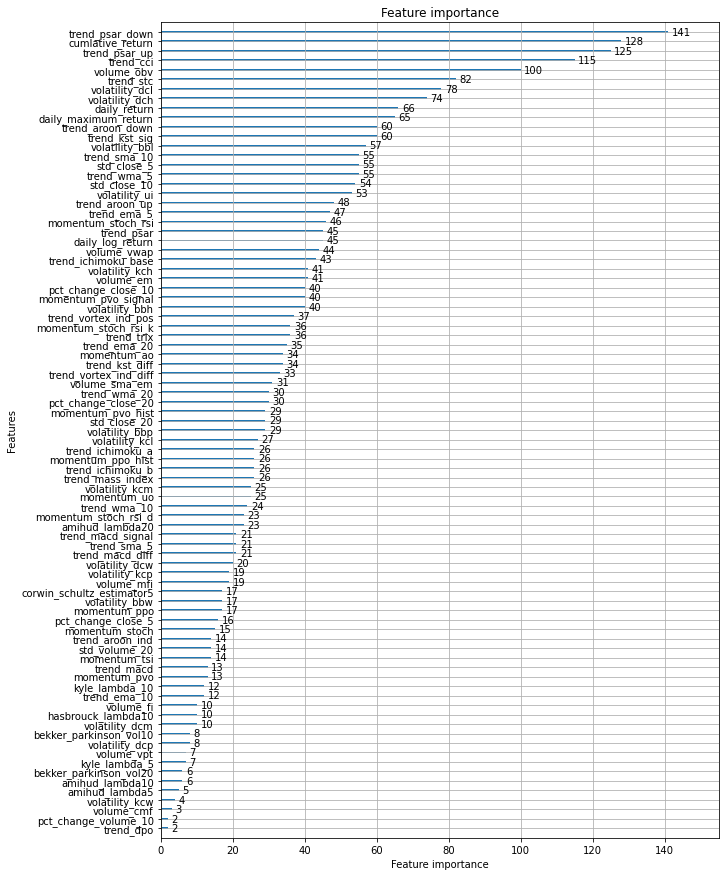

In [81]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 15))
plot_importance(clf_pi, ax=ax)

In [85]:
lgb.LGBMClassifier()

LGBMClassifier()